<h2><center> Welcome to the Cryptojacking Detection Challenge Starter Notebook</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=1afxycLZz1AovI0MjqEIiXyziEVWnUkNG" width = "750" height = '500' alt="Cryptojacking Detection Challenge"/>

*About the problem*
> Cryptojacking is a cyber-attack utilizing malicious scripts similar to those from large cryptocurrency houses to illegally mine data without users being aware. These attacks are stealthy and difficult to detect or analyze, often leading to decreased computing speeds for users as well as crashes due to straining of computational resources.


*The objective of this challenge is*:
> classify network activity from various websites as either cryptojacking or not based on features related to both network-based and host-based data.



## Table of contents:

1. [Importing Libraries](#Libraries)
2. [Loading Data](#Data)
3. [Statistical Summaries](#Statistics)
4. [Missing Values and Duplicates](#Missing)
5. [Target Distribution](#Engineering)
6. [Modelling](#Modelling)

<a name="Libraries"></a>
## 1. Importing Libraries


In [1]:
SEED = 2023

# Import libraries
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.feature_selection import RFECV

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

<a name="Data"></a>
## 2. Loading Data

In [2]:
# Load files
train = pd.read_csv('../Data/Train.csv')
test = pd.read_csv('../Data/Test.csv')
samplesubmission = pd.read_csv('../Data/SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius,Label
0,ID_4W8AP96UO6,114.798900,3790.450939,28.0,0.427078,6.162365,21.220403,58.492773,63.959387,0.621206,0.521813,24.624612,0.0,1001.533430,27.190843,1
1,ID_UD3TM0ZYND,14.154240,5182.451722,28.0,0.138876,5.399498,0.000000,22.886762,29.508369,0.422183,0.444403,0.044440,0.0,1089.121009,30.150941,0
2,ID_XAG1HC0HWM,0.044444,120.821253,28.0,0.000000,1.577765,0.000000,11.733239,12.888786,0.177776,0.155554,0.044444,0.0,322.464081,28.163287,0
3,ID_CEXD05IR09,31.369916,127228.251100,31.0,0.523750,15.981107,5.356671,602.125436,6976.986795,3.311801,5.756755,5.623394,0.0,12015.169690,34.204404,0
4,ID_X6E97FT8IF,5.046181,1091.620117,25.0,0.069468,1.356022,0.000000,16.138887,13.271234,0.155609,0.133379,0.000000,0.0,550.989619,31.466889,1


In [3]:
# Preview test dataset
test.head()

,ID,I/O Data Operations,I/O Data Bytes,Number of subprocesses,Time on processor,Disk Reading/sec,Disc Writing/sec,Bytes Sent/sent,Received Bytes (HTTP),Network packets sent,Network packets received,Pages Read/sec,Pages Input/sec,Page Errors/sec,Confirmed byte radius
0,ID_L7RNFK5JC9,32.709430,121124.141400,30.407359,0.496719,3.999064,0.000000,335.565884,737.338490,1.844013,1.910664,0.311038,0.0,726.318848,20.008686
1,ID_KUTY5K1G5F,2.065990,2029.713475,29.000000,0.000000,3.665467,0.000000,63.845771,41.119875,0.733093,0.577589,0.044430,0.0,385.473839,33.015399
2,ID_H6PJWKU831,114.524684,3888.550764,28.000000,0.486075,0.777719,0.199985,11.354698,11.332477,0.177764,0.133323,0.000000,0.0,504.828540,30.091141
3,ID_DNQXNVTXHE,27.036810,5581.324782,25.000000,0.314968,1.789015,0.000000,44.297028,13.430214,0.302369,0.125987,0.000000,0.0,465.950312,22.211252
4,ID_8CRTF1BJOD,1.177267,176.634467,28.000000,0.000000,1.710369,0.000000,88.161746,57.508380,0.888503,0.777440,0.000000,0.0,771.665166,31.032570


In [4]:
# Preview sample submission file
samplesubmission.head()

,ID,Target
0,ID_L7RNFK5JC9,0
1,ID_KUTY5K1G5F,0
2,ID_H6PJWKU831,0
3,ID_DNQXNVTXHE,0
4,ID_8CRTF1BJOD,0


In [5]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((8908, 16), (3818, 15), (3818, 2))

<a name="Statistics"></a>
## 3. Statistical Summaries

In [6]:
# Train statistical summary
train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,8908,8908,ID_4W8AP96UO6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I/O Data Operations,8908.0,NaN,NaN,NaN,36.429205,75.884647,0.0,1.394404,11.613803,34.494953,1795.316255
I/O Data Bytes,8908.0,NaN,NaN,NaN,113556.435854,489684.616342,0.0,813.631825,4930.481627,39403.570772,4677280.322
Number of subprocesses,8908.0,NaN,NaN,NaN,29.8119,5.691411,1.0,27.0,28.0,30.0,51.0
Time on processor,8908.0,NaN,NaN,NaN,0.496405,1.593626,0.0,0.0,0.034734,0.45135,25.246148
Disk Reading/sec,8908.0,NaN,NaN,NaN,5.35326,19.28669,0.044459,0.755629,1.711077,5.845619,1064.819285
Disc Writing/sec,8908.0,NaN,NaN,NaN,1.046153,15.667814,0.0,0.0,0.0,0.022229,831.503948
Bytes Sent/sent,8908.0,NaN,NaN,NaN,559.546628,1939.745234,1.19789,33.8438,67.366295,221.31481,98097.7843
Received Bytes (HTTP),8908.0,NaN,NaN,NaN,16558.044068,90428.02521,1.554938,27.377705,89.057696,561.381397,4812144.222
Network packets sent,8908.0,NaN,NaN,NaN,4.795485,20.797585,0.022183,0.399999,0.710898,1.555063,1118.878021


<a name="Missing"></a>
## 4. Missing Values and Duplicates

In [7]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(False, False)

In [8]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

There are no missing values or duplicates

<a name="Class Distribution"></a>
## 5. Target Distribution

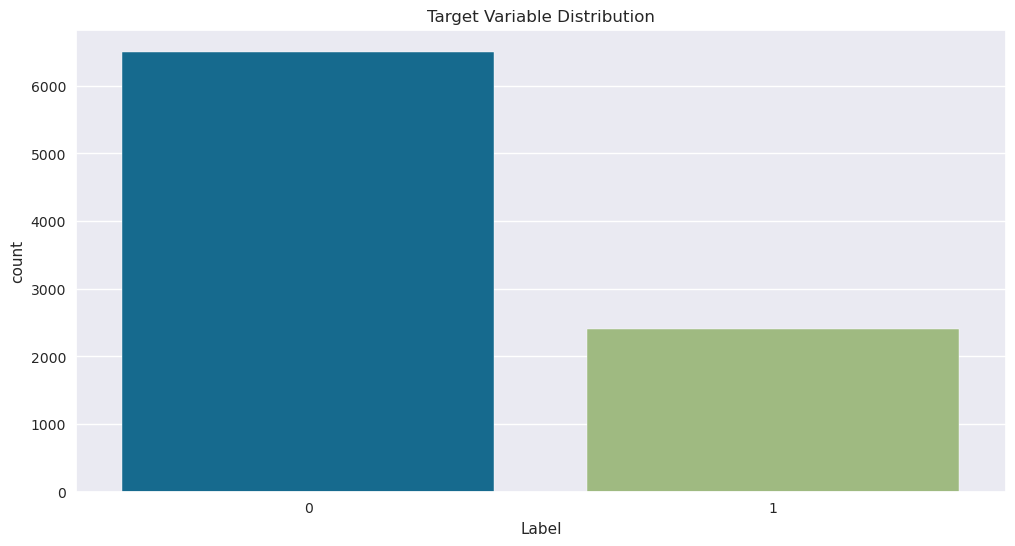

In [9]:
# A box plot showing outliers
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
sns.countplot(x = 'Label', data = train)
plt.title('Target Variable Distribution')
plt.show()

There is a class imbalance in our dataset

/tmp/ipykernel_19597/3209112519.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


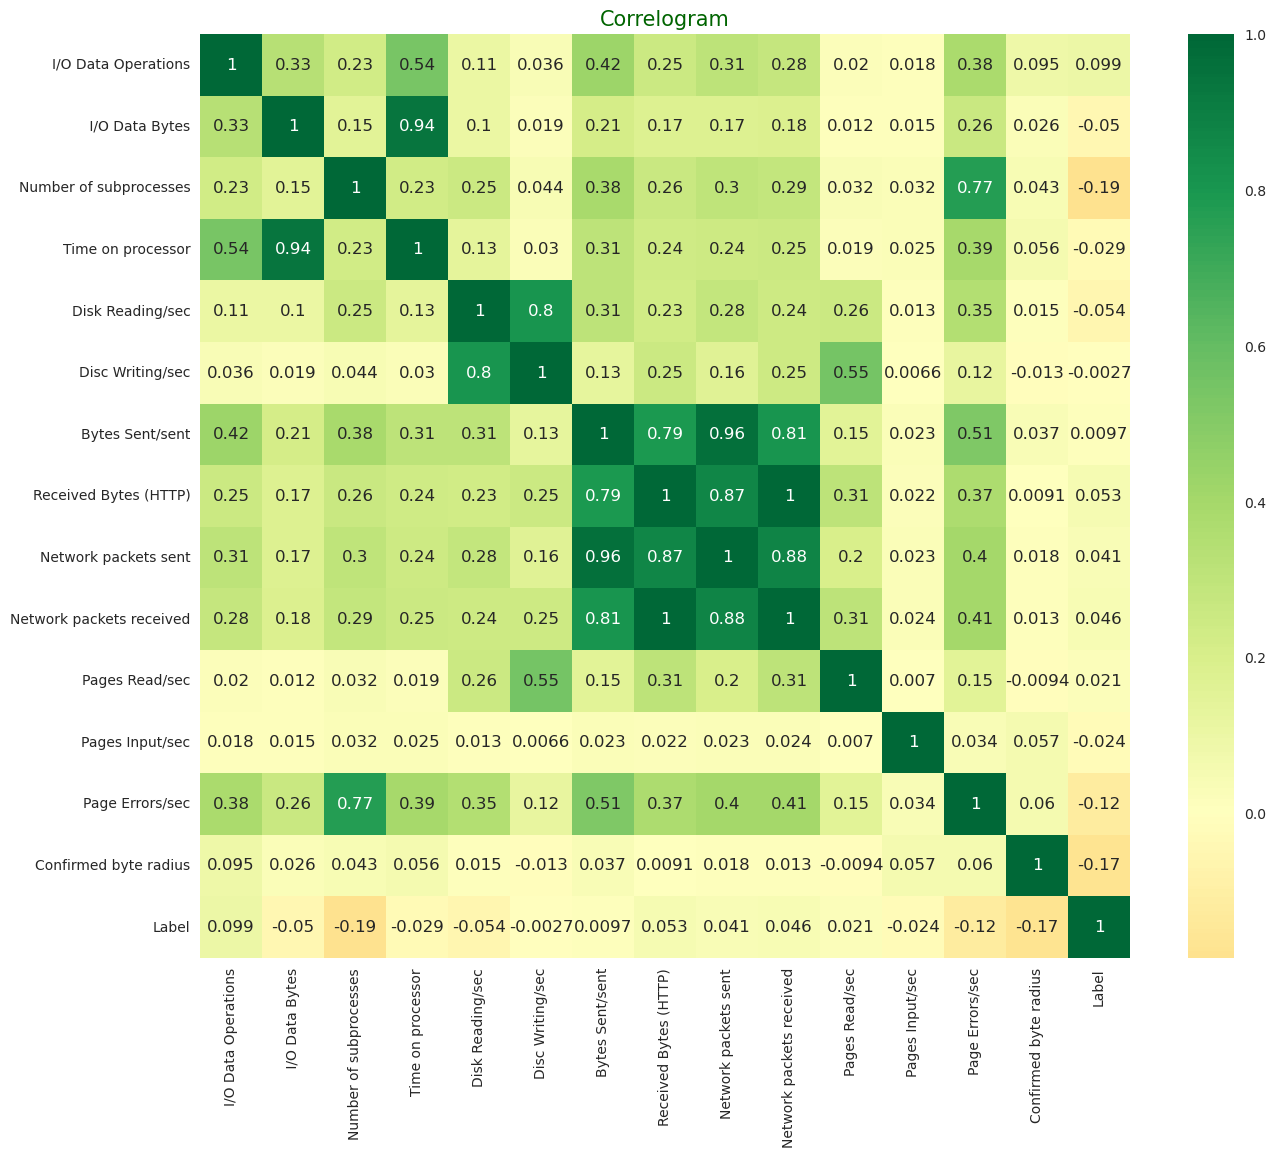

In [10]:
# Plotting a heatmap to show correlations between variables
corr = train.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

Most features are not strongly correlated with the target

<a name="Preprocess"></a>
## 6. Modeling

In [11]:
#scale numerical features for logistic model
features = train.drop(columns=['ID','Label']).columns
target = 'Label'

# define standard scaler
scaler = StandardScaler()

# transform data
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

In [12]:
#split train data into train and validation set
X_train, X_test, y_train, y_test = train_test_split(train[features], 
                                                    train[target].to_frame(),
                                                    stratify=train[target], #to account for class imbalance
                                                    test_size=0.2,
                                                    random_state=SEED
                                                    )

# Feature Selection

In [13]:
# split method for feature selection

kfold= StratifiedKFold(n_splits=5, random_state=2023, shuffle=True)

In [14]:
def select_features(X_train, y_train, X_test, algorithm: object, step: int, min_feature: int) -> pd.DataFrame:
    """Function to select all relevant features in the dataset
    
    Parameters:
        datasets: the training and test dataset needed to train the model
        algorithm: algorithm used to select features
        step: number of steps to take during elimination process
        min_feature: minimum number of features to select
        
    Return:
        dataset: new dataset with the selected features
    """
    
    # instantiate the algorithm
    algo = RFECV(estimator=algorithm, 
                 step=step, 
                 cv=kfold,
                 min_features_to_select=min_feature, 
                 scoring='f1', 
                 verbose=2, 
                 n_jobs=-1)
    
    # fit the algorithm to the data
    algo.fit(X_train, y_train)
    
    # transform train input data
    X_train_ts = algo.transform(X_train)
    
    # transform test input data
    X_test_ts = algo.transform(X_test)
    
    return X_train_ts, X_test_ts, algo

In [15]:
# applying feature selection method

algo = XGBClassifier()
min_feature = 1
step = 1

X_train_fs, X_test_fs, algo = select_features(X_train, y_train, X_test, algo, step, min_feature)

print('Relevant number of features:', algo.n_features_)
print('\nHere are the features:')
print('----------------------------------')

pd.DataFrame(X_train.columns[algo.ranking_ == 1], columns=['Selected Features'])

Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Relevant number of features: 11

Here are the features:
----------------------------------


,Selected Features
0,I/O Data Operations
1,I/O Data Bytes
2,Number of subprocesses
3,Time on processor
4,Disk Reading/sec
5,Disc Writing/sec
6,Bytes Sent/sent
7,Received Bytes (HTTP)
8,Network packets received
9,Page Errors/sec


In [16]:
# creating new train and test data using selected features

X_train_fs = pd.DataFrame(X_train_fs, columns=list(X_train.columns[algo.ranking_ == 1]))
X_test_fs = pd.DataFrame(X_test_fs, columns=list(X_test.columns[algo.ranking_ == 1]))

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 4, 5],
              'min_child_weight': [1, 3, 5]}

In [35]:
#X_train_fs_z_scaler

model = XGBClassifier(learning_rate=0.7, max_depth=10, min_child_weight=1)
model.fit(X_train_fs, y_train)

#print('Accuracy  classifier on training set: {:.3f}'.format(estimator_xgb.score(X_train_fs_z_scaler, y_train)))
print('Accuracy  classifier on test set: {:.4f}'.format(model.score(X_test_fs, y_test)))

y_pred = model.predict(X_test_fs)

f1 = f1_score(y_test, y_pred)
print('f1 score: {:.4f}'.format(f1))

In [36]:
# model = XGBClassifier(learning_rate=0.5, max_depth=5, min_child_weight=3)

# grid_search = GridSearchCV(model, param_grid, cv=5)
# grid_search.fit(X_train_fs, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)

In [37]:
# Specify the target classes
classes = ['No Affected', 'Affected']

# instantiate the report visualizer
visualizer = ClassificationReport(model, classes=classes, support=True)

# fit and visualize it 
visualizer.fit(X_train_fs, y_train)        
visualizer.score(X_test_fs, y_test)       
visualizer.show()    
plt.show()

In [38]:
# instantiate the matrix
crypto_cm = ConfusionMatrix(model, classes=classes,label_encoder={0: 'Not Affected', 1: 'Affected'})

# fit and plot the results
crypto_cm.fit(X_train_fs, y_train)
crypto_cm.score(X_test_fs, y_test)
crypto_cm.show()
plt.show()

### Submission

In [39]:
# get selected columns

pred_columns = X_train_fs.columns

In [40]:
# make predictions on test set

test['Target'] = model.predict(test[pred_columns])

In [41]:
# get id and target column

sub = test[['ID', 'Target']]

In [42]:
sub.head()

In [43]:
# create submission file

sub.to_csv('../Submissions/final_team8_submission4.csv', index=False)